<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/CNN_fwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import the necessary packages**

In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import tqdm
import torch.distributions as distr

In [2]:
%pip install torchmetrics --quiet

In [3]:
import torchmetrics
import torchvision
from torchvision import transforms as T
from matplotlib import pyplot as plt

In [4]:
from torch import nn
from torch.nn import functional as F

In [5]:
import functorch as fc
from functorch import jvp
from functools import partial

In [6]:
import time

# **Loading and preprocessing the data**

In [7]:
#Load the dataset
train_data = torchvision.datasets.KMNIST('./data', train=True, download=True)

In [8]:
# This loads data with data conversion.
train_data = torchvision.datasets.KMNIST('./data', train=True, transform=T.ToTensor())

tensor(8)


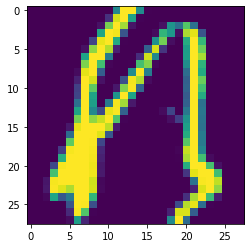

In [9]:
# We visualize the first sample of the dataset
plt.imshow(train_data.data[0])
print(train_data.targets[0])

In [10]:
# We use the loader to shuffle the elements of the dataset
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)

In [11]:
# We get the first element of the loader
xb, yb = next(iter(train_loader))

In [12]:
# Load the testset
test_data = torchvision.datasets.KMNIST('./data', train=False, transform=T.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False)

# **Define Convolutional Neural Network**

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, 2, 3, padding=1)

        self.conv2 = nn.Conv2d(2, 4, 3, padding=1)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*14*14, 64)

        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.reshape((-1, 4*14*14))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.reshape(1, -1)
        return torch.softmax(x, 1)

In [14]:
# We check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **Initialize the parameters**

In [15]:
# We initialize the parameters randomly and the model with an input size
#conv1w = torch.FloatTensor(8, 1, 3, 3).uniform_(-1, 1)
#conv1b = torch.randint(-1, 1, (8, ), dtype=torch.float32, requires_grad=False)
#conv2w = torch.randint(-1, 1, (16, 8, 3, 3), dtype=torch.float32, requires_grad=False)
#conv2b = torch.randint(-1, 1, (16, ), dtype=torch.float32, requires_grad=False)
#fc1w = torch.randint(-1, 1, (1024, 3136), dtype=torch.float32, requires_grad=False)
#fc1b = torch.randint(-1, 1, (1024, ), dtype=torch.float32, requires_grad=False)
#fc2w = torch.randint(-1, 1, (10, 1024), dtype=torch.float32, requires_grad=False)
#fc2b = torch.randint(-1, 1, (10, ), dtype=torch.float32, requires_grad=False)
cnn = SimpleCNN(1).to(device)

In [16]:
 # Get the functional version of the model with functorch
fcnn, params = fc.make_functional(cnn)
fcnn(params, xb)

tensor([[0.1104, 0.1004, 0.0909, 0.0946, 0.0962, 0.0908, 0.1036, 0.1031, 0.1147,
         0.0952]], grad_fn=<SoftmaxBackward0>)

In [17]:
# We try our model with the first example
print(cnn(xb.to(device))[0])

tensor([0.1104, 0.1004, 0.0909, 0.0946, 0.0962, 0.0908, 0.1036, 0.1031, 0.1147,
        0.0952], grad_fn=<SelectBackward0>)


Calculate predictions

In [18]:
def pred(sample_size, loader, model):
  Xtrain = torch.randn(sample_size, 1, 28, 28)
  ytrain = torch.randn(sample_size)
  ypred = torch.randn(sample_size, 10)

  for i in range(sample_size):
    xb, yb = next(iter(loader))
    Xtrain[i] = xb
    ytrain[i] = yb
    ypred[i] = model(xb)
  return Xtrain, ytrain, ypred

In [19]:
Xtrain, ytrain, ypred = pred(500, train_loader, cnn)

# **Define accuracy**

In [22]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue.long()).float().mean()

In [24]:
# Average accuracy at initialization is 10% (random guessing).
accuracy(ytrain, ypred)

tensor(0.0700)

# **Define Cross-Entropy**

In [48]:
def cross_entropy(params, fmodel, ytrue, x):
  ypred=torch.randn((ytrue.shape[0],10))
  for j in range(ytrue.shape[0]):
    ypred[j] = fmodel(params, x[j])
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue.long()].log().mean()

In [39]:
print(cross_entropy(params, fcnn, ytrain, Xtrain))

tensor(2.3142, grad_fn=<NegBackward0>)


# **Other optimization functions**

In [28]:
def beale_function(x):
  return (torch.pow(torch.tensor([1.5])-x[0]+x[0]*x[1],2) + torch.pow(torch.tensor([2.25])-x[0]+x[0]*torch.pow(x[1],2),2)+torch.pow(torch.tensor([2.625])-x[0]+x[0]*torch.pow(x[1],3),2))

In [29]:
def rosenbrock_function(x):
  sum=0
  for p in x.size():
    for i in range (x.size(1)-1):
      sum += (100*torch.pow(x[i+1] - torch.pow(x[i], 2), 2) + torch.pow(x[i]-1, 2))
  return sum

# **Train and evaluate the network**

In [61]:
def train_fwd_gradient(train_loader):

  l_rate0 = 0.05

  cnn = SimpleCNN(1).to(device)
  fcnn, params = fc.make_functional(cnn)
  Xtrain, ytrain, ypred = pred(500, train_loader, cnn)

  Xtest, ytest, ypredtest = pred(100, test_loader, cnn)

  loss = cross_entropy(params, fcnn, ytrain, Xtrain)
  t=0
  t0 = time.time()

  while (loss>0.5) :

    v = tuple([torch.randn_like(p) for p in params])
    g = partial(cross_entropy, fmodel = fcnn, ytrue=ytrain, x=Xtrain)

    loss, dt = jvp(g, (params, ), (v, ))
    print('dt', dt)

    with torch.no_grad():
      for j, p in enumerate(params):
        gt = v[j]*dt
        p -= l_rate0*gt

    # We add the execution time of the iteration
    t1=time.time()
    t+=t1-t0
    t0=t1
    print('Time', t, 'loss', loss)

  return params

In [62]:
params = train_fwd_gradient(train_loader)

dt tensor(0.0728, grad_fn=<NegBackward0>)
Time 0.7180399894714355 loss tensor(2.3070, grad_fn=<AliasBackward0>)
dt tensor(-0.0058, grad_fn=<NegBackward0>)
Time 1.5466196537017822 loss tensor(2.3068, grad_fn=<AliasBackward0>)
dt tensor(-0.0054, grad_fn=<NegBackward0>)
Time 2.3913164138793945 loss tensor(2.3068, grad_fn=<AliasBackward0>)
dt tensor(-0.0042, grad_fn=<NegBackward0>)
Time 3.170753240585327 loss tensor(2.3068, grad_fn=<AliasBackward0>)
dt tensor(-0.0332, grad_fn=<NegBackward0>)
Time 4.296854734420776 loss tensor(2.3068, grad_fn=<AliasBackward0>)
dt tensor(-0.0621, grad_fn=<NegBackward0>)
Time 5.53041672706604 loss tensor(2.3067, grad_fn=<AliasBackward0>)
dt tensor(0.0525, grad_fn=<NegBackward0>)
Time 6.559858798980713 loss tensor(2.3066, grad_fn=<AliasBackward0>)
dt tensor(0.0708, grad_fn=<NegBackward0>)
Time 7.348798513412476 loss tensor(2.3064, grad_fn=<AliasBackward0>)
dt tensor(-0.0824, grad_fn=<NegBackward0>)
Time 8.203672409057617 loss tensor(2.3062, grad_fn=<AliasBackw

In [ ]:
for epoch in range(1):

  cnn.train()
  for i in range(1):
    xb, yb = next(iter(train_loader))
    xb = xb.to(device)
    yb = yb.to(device)

    conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b = train_fwd_gradient(xb, yb)
    cnn = SimpleCNN(1, conv1w, conv1b, conv2w, conv2b, conv3w, conv3b, conv4w, conv4b, fc1w, fc1b, fc2w, fc2b).to(device)

    #Update cnn parameters
    #Recalculate ypred and loss
    #MIRAR NN_LAB_LOGISITC_REGRESSION
    #CALCULAR G(THETA) QUE ES EL GRADIENTE Y APLICARLO A LOS PARAMETROS DEL CNN, LOS WEIGHTS